# Лабораторная работа #5
## Классификация

### Предобработка данных

Для выполнения классификации необходимо совершить заново предобработку данных датасета с прошлой лабораторной, Были импортированы необходимые библиотеки

In [29]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import matplotlib.pyplot as plt

Был загружен датасет `1heart.csv`, в котором находится информация о пациентах с анализами для определения наличия заболевания сердца. Были выведены 5 записей, чтобы оценить датасет.

In [30]:
data = pd.read_csv('1heart.csv', sep=',')

In [31]:
data['ExerciseAngina'] = data['ExerciseAngina'].map({'N': 0, 'Y': 1})

data['ExerciseAngina'].value_counts()

ExerciseAngina
0    553
1    372
Name: count, dtype: int64

In [32]:
nans = data[data.isnull().any(axis=1)]

In [33]:
data = data.dropna()

In [34]:
invalid_rows = data[pd.to_numeric(data['Cholesterol'], errors='coerce').isna()]

invalid_rows

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
922,57,F,ASY,140.0,a241,0,Normal,123.0,1,0.2,Flat,1


In [35]:
data['Cholesterol'] = data['Cholesterol'].replace('a241','241')
data['Cholesterol'] = pd.to_numeric(data['Cholesterol'])

In [36]:
data['RestingBP'] = data['RestingBP'].replace(0, data['RestingBP'].median())
data['Cholesterol'] = data['Cholesterol'].replace(0, data['Cholesterol'].median())

Предобработка завершена, можно анализировать данный датасет.

Была выделена целевая переменная `HeartDisease`, по которой была выведена матрица диаграмм

In [26]:
import seaborn as sns

sns.pairplot(data, hue= 'HeartDisease')

По данной матрице диаграмм видно, что данные имеют высокую степень перекрытия между группами, что затрудняет чёткое разделение классов. Наиболее отличающиеся признаки — это `Oldpeak`, `ExerciseAngina`, и `MaxHR`. Для пациентов с больным сердцем значения `Oldpeak` и `ExerciseAngina` смещены вверх, а `MaxHR` наоборот вниз. 

### Выполнение классификации

Был создан датасет только из числовых столбцов и удален столбец, который будет использоваться как целевая переменная. Также все значения были нормализованы

In [27]:
from sklearn.model_selection import train_test_split

num_data = data.select_dtypes(exclude=['object'])
indie_num_data = num_data.drop(columns='HeartDisease')

X = indie_num_data
y = num_data['HeartDisease']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) 


Далее были разработаны предсказательные модели `K-Nearest Neighbours`, `Decision Tree`, `Logistic Regression` и `RandomForest` и выведены основные метрики для оценивания их точности и эффективности классификации в данном контексте.

In [28]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score,

models = {
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=500),
    "Random Forest": RandomForestClassifier(random_state=42, n_estimators=100)
}

# Train and evaluate models
results = []
for name, model in models.items():
    model.fit(X_train, y_train)  # Train the model
    y_pred = model.predict(X_test)  # Predict on the test set

    accuracy = accuracy_score(y_test, y_pred)  # Evaluate accuracy
    precision = precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')
    f1 = f1_score(y_test, y_pred, average='binary')
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
    classification_error = 1 - accuracy_score(y_test, y_pred)

    results.append({
        "Model": name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "Balanced Accuracy": balanced_accuracy,
        "Classification Error": classification_error
    })

# Prepare and display the updated results
summary = pd.DataFrame(results)

display(summary)


SyntaxError: trailing comma not allowed without surrounding parentheses (2565623243.py, line 5)

`Logistic Regression` и `Random Forest` имеют наивысшие знаения метрик среди остальных моделей, что указывает на их способность эффективно классифицировать данные. `Decision Tree` демонстрирует средние результаты, а `K-Nearest Neighbors` имеет наименьшие значения всех метрик, что указывает на его слабую производительность.

Далее была построена матрица неточностей, которая состоит из 4 элементов: 
+ `True Positive` (TP) - значения, которые были правильно идентифицированы как положительные 
+ `False Positive` (FP) - значения, которые были неправильно инентифицированы как положительные
+ `True Negative` (TN) - значения, которые были правилно определены как отрицательные
+ `False Negative` (FN) -значения, которые были неправаильно определены как отрицательные

Построить данную матрицу можно с помощью метрики `confusion_matrix` и библиотеки `seaborn`

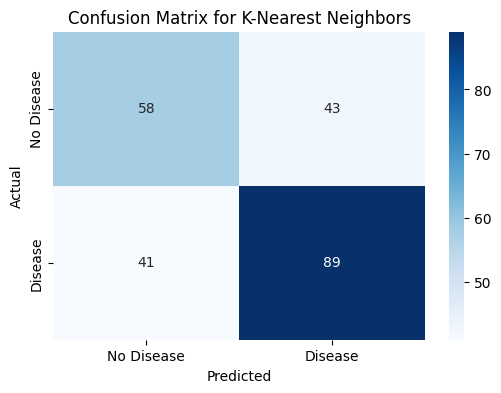

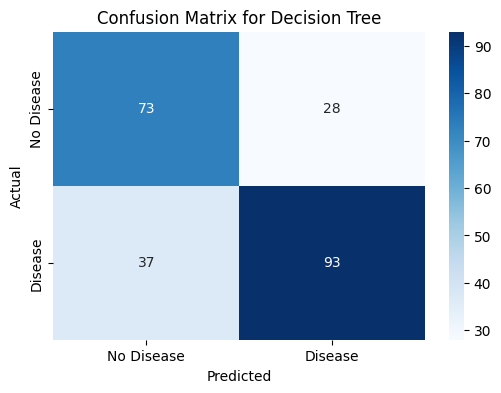

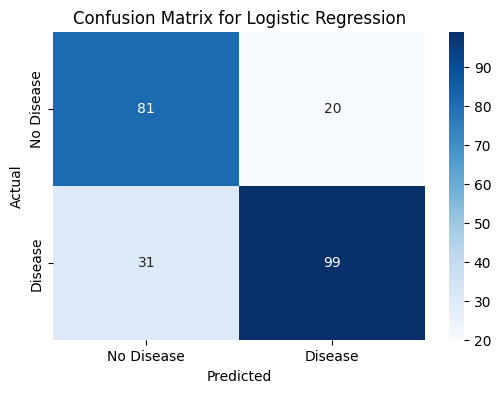

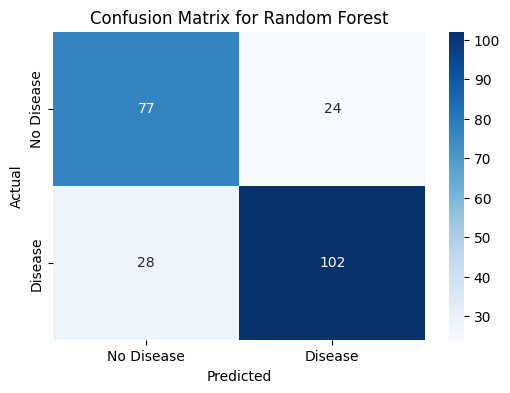

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

confusion_matrices = {}

for name, model in models.items():
    y_pred = model.predict(X_test)
    # Store confusion matrix
    confusion_matrices[name] = confusion_matrix(y_test, y_pred)


# Plot confusion matrices
for name, cm in confusion_matrices.items():
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["No Disease", "Disease"], yticklabels=["No Disease", "Disease"])
    plt.title(f"Confusion Matrix for {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()




Матрицы подтверждают, что Logistic Regression и Random Forest совершают меньше ошибок классификации, особенно ложных положительных и отрицательных. Decision Tree допустим, но менее точен, а K-Nearest Neighbors показывает высокий уровень ошибок, что подтверждает его низкую производительность.

Далее был построен график ROC-кривой, который показывает, как меняется качество бинарного классификатора при разных значениях порога вероятности. В данном графике чем выше находится линия кривой от диагонали случайного классификатора (который показывает, что алгоритм классифицировал значения случайным образом), тем больше у него AUC (площадь под кривой), тем соответственно модель лучше классифицирует данные. 

Данный график был построен с помощью метода `roc_curve`, а значения AUC были посчитаны с помощью метода `auc`

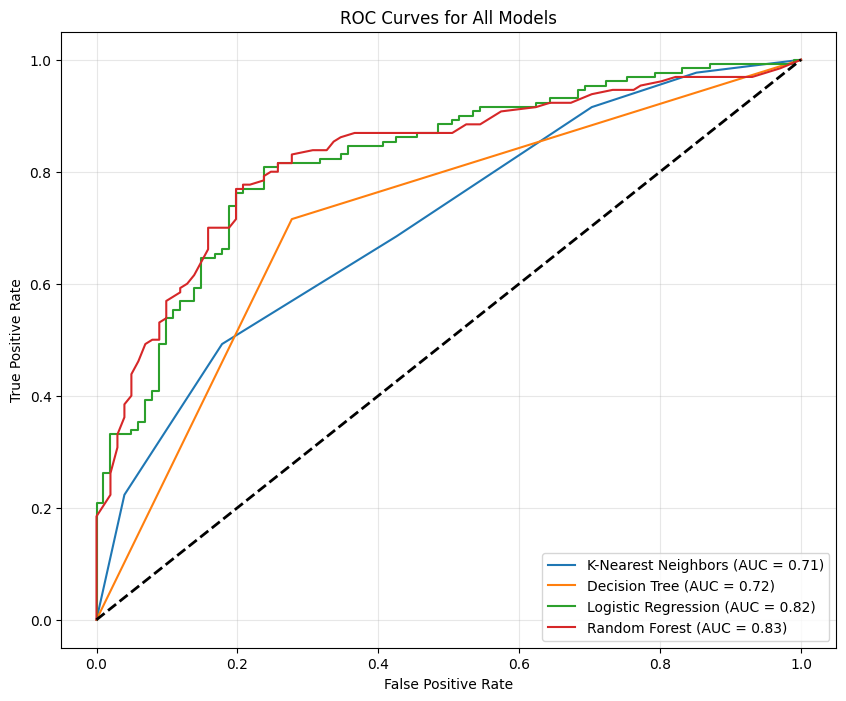

In [ ]:
from sklearn.metrics import roc_curve, auc

# Plot ROC curves for each model
plt.figure(figsize=(10, 8))

for name, model in models.items():
    y_proba = model.predict_proba(X_test)[:, 1]  # Get probability scores for the positive class
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

# Plot formatting
plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line
plt.title("ROC Curves for All Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()


На основе построенного графика ROC-кривых видно, что модели Logistic Regression и Random Forest демонстрируют наиболее высокие показатели качества классификации, так как их кривые находятся ближе к верхнему левому углу. Значения AUC для этих моделей выше по сравнению с остальными, что указывает на их способность более точно различать положительный и отрицательный классы.

Метод K-Nearest Neighbours уступает остальным моделям, так как её кривая находится ближе к диагональной линии, что говорит о меньшей эффективности классификации.

### Вывод

В данной лабораторной работе была проведена бинарная классификация с помощью моделей K-Nearest Neighbours, Decision Tree, Logistic Regression и Random Forest для предсказания постановления диагноза заболевания сердца пациентам. Были обучены 4 модели для решения этого задания, а также просчитаны метрики для каждой модели, построены матрицы неточностей и график ROC-кривых.

Результаты проведенной работы показывают, что по всем метрикам лучше всего решают данную задачу модели Logistic Regression (accuracy 0.779, f1 score 0.795, AUC 0.83) и Random Forest (accuracy 0.775, f1 score 0.797 AUC 0.72), которые показывают довольно высокие значения, близкие друг к другу. Средние результаты по всем метрикам показала модель Decision Tree (accuracy 0.72, AUC 0.83), а хуже всех справилась модель KNN, показавшая наименьшие значения метрик - accuracy 0.64, f1 score 0.68, значение AUC 0.71